# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

## Problem Overview
Let’s say your apartment lease is ending at the end of the year, and you need to find a new apartment. There are a lot of criteria you can use to help find a neighborhood you’d like to live in. One thing you care a lot about is a quiet neighborhood with a lot of greenery. 

Using NYC Open Data datasets and Zillow’s historic monthly rent averages, you will be creating a single Jupyter notebook to download, clean, and store data, as well as defining a set of SQL queries and visualizations to help answer questions of yours in search of a great area to live within your budget.


## Setup

In [1]:
# Import statements needed for the project
import math
from datetime import datetime, timedelta
from datetime import date
import numpy as np
import json
import pathlib
import urllib.parse
import psycopg2
import psycopg2.extras
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import seaborn as sns
import pandas as pd
import requests
import shapely
import sqlalchemy as db
import os
import folium

from shapely.geometry import Point
from sqlalchemy.orm import declarative_base
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Float, TIMESTAMP, Date, text

import re
import geoalchemy2 as gdb 
from geoalchemy2 import Geometry, WKTElement

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geoplot as gplt
import geoplot.crs as gcrs
from pathlib import PosixPath
from pyproj import CRS, Transformer
from shapely.ops import transform
from shapely.geometry import Point
from shapely.wkb import dumps
from pathlib import Path
import geodatasets
import contextily as cx

In [2]:
# Constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("data")
COMPLAINTS_DATE_DIR =  pathlib.Path("data/311_data")
ZIPCODE_DATA_FILE = DATA_DIR /"nyc_zipcodes.shp"
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"

# Token Related Information Variable
APP_TOKEN = "WZUCCEUBzIBROFj20iUxnoyQV"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/resource/"
NYC_DATA_311 = "erm2-nwe9.json"
NYC_DATA_TREES = "5rq2-4hqu.json"

DB_NAME = "Project4501"
DB_USER = "postgres"
DB_PASSWORD = "727403"
DB_HOST = 'localhost'
DB_URL=f'postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}/{DB_NAME}'
DB_SCHEMA_FILE = "schema.sql"

crs='EPSG:4326'

rent_month_dict = {}
# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("queries")

In [3]:
# Make sure the QUERY_DIRECTORY exists
if not QUERY_DIR.exists():
    QUERY_DIR.mkdir()

## Part 1: Data Preprocessing

Four Dataset is downloaded and cleaned for part 1, they are NYC_311, NYC_ZILLOW, ZIPCODE and NYC_TREES
Here are some descriptions of the datasets:

1. `NYC_311` is the downloaded data where the 311 requests come from, we use the application token generated to download the data, since the whole data file is too large, we set a limit equals to 700000 and use `soql` command to store it in 30 JSON files. Through this we downloaded 1380551 data from the whole dataset as a population sample for this project.

2. `NYC_TREE` is the downloaded data from the tree census part, we adopt a similar method here, set a limit of 700000, but without the use of 30 JSON files, we got 683788 data here as a population sample for this project.

3. `NYC_ZILLOW` is the manually downloaded data from the shared Google file, which includes the historical monthly average rents by zip code from Zillow, we only keep the `zipcode`, `recorded_date` and `rent` variable as they are the only needed data for analysis in part 3 and part 4.

4. `NYC_ZIPCODE` is the manually downloaded data from the shared Google file, which includes the `shp` file for the geometry boundary of New York City.

### Download of NYC_311 request data

In [4]:
def download_nyc_311_data(url, force=False):
    json_files = [f"{i}.json" for i in range(30)]
    filenames = [COMPLAINTS_DATE_DIR / i for i in json_files ]
    
    if not COMPLAINTS_DATE_DIR.exists():
        COMPLAINTS_DATE_DIR.mkdir()
    
    limit = 700000
    for filename in filenames:
        if force or not filename.exists():
            print(f"Downloading")
            offset = int(filename.stem) * 700000
            all_entries = []
            selected_columns = ["unique_key", "created_date", "complaint_type", "incident_zip", "location"]
            soql_query311 = f"{url}?$$app_token={APP_TOKEN}&$select={','.join(selected_columns)}&$limit={700000}&$offset={offset}"
            response = requests.get(soql_query311)
            if response.status_code == 200: 
                entries = response.json()       
        
            with open(filename, "w") as f:
                json.dump(entries, f)
            print(f"Finished download")
            
    print(f"load data from {filenames} to {filenames}...")
    return filenames[:2]

### Download of NYC_Tree Data

In [5]:
def download_nyc_tree_data(url, force=False):
    url_path1 = urllib.parse.urlparse(url).path.split("/")[-1]
    filename = DATA_DIR / url_path1
    
    if not DATA_DIR.exists():
        DATA_DIR.mkdir()

    if force or not filename.exists():
        print(f"Downloing")
        
        limit = 700000
        all_entries = []
        offset = 0
        selected_columns = ["tree_id", "zipcode", "the_geom", "spc_common", "health", "status","latitude", "longitude"]
        end = 700000
        
        while offset < end:  
            total = limit+offset
            print(f"start from {offset} while total is {total}")
            soql_querytree = f"{url}?$$app_token={APP_TOKEN}&$select={','.join(selected_columns)}&$limit=700000&$offset={offset}"
            response = requests.get(soql_querytree)
            if response.status_code == 200: 
                entries = response.json()
                all_entries.extend(entries)
                offset += limit
                  
        with open(filename, "w") as f:
            json.dump(all_entries, f)
        print(f"Finished download")

    return filename

### Load and clean of the zipcode data

In [6]:
def load_and_clean_zipcodes(zipcode_datafile):
    global unique_zipcodes
    gdf = gpd.read_file(zipcode_datafile).to_crs(epsg=4326)
    unique_zipcodes_df = gdf[["ZIPCODE", "geometry"]].drop_duplicates(subset="ZIPCODE").reset_index(drop=True)
    unique_zipcodes = unique_zipcodes_df["ZIPCODE"]

    return unique_zipcodes_df

### Download and clean of the 311 data

In [7]:
def download_and_clean_311_data():
    filenames = download_nyc_311_data(f"{BASE_NYC_DATA_URL}{NYC_DATA_311}")
    processed_frames = []

    for filename in filenames:
        df = pd.read_json(filename, dtype="object")
        
        if "location" in df.columns:
            # Extract latitude and longitude
            df["latitude"] = df["location"].apply(lambda x: x.get("latitude") if isinstance(x, dict) else None)
            df["longitude"] = df["location"].apply(lambda x: x.get("longitude") if isinstance(x, dict) else None)
            
            # Create geometry for valid lat-long pairs
            df["geometry"] = [
                Point(float(lon), float(lat)) if pd.notna(lon) and pd.notna(lat) else None 
                for lat, lon in zip(df["latitude"], df["longitude"])
            ]

            # Drop unnecessary columns
            df.drop(columns=["location", "longitude", "latitude"], inplace=True)

            # Filter by incident zip and unique zipcodes
            df = df[pd.notna(df["incident_zip"]) & df["incident_zip"].isin(unique_zipcodes)]

            # Create a GeoDataFrame
            gdf = gpd.GeoDataFrame(df, geometry="geometry")
            gdf.crs = "EPSG:4326"
            
            processed_frames.append(gdf)

    # Concatenate all GeoDataFrames
    final_gdf = gpd.GeoDataFrame(pd.concat(processed_frames, ignore_index=True, sort=False)).drop_duplicates(subset=['unique_key']).reset_index(drop=True)
    return final_gdf


### Download and clean of the tree data

In [8]:
def download_and_clean_tree_data():
    filename = download_nyc_tree_data(f"{BASE_NYC_DATA_URL}{NYC_DATA_TREES}")
    tree_df = pd.read_json(filename, dtype='object')

    tree_df["geometry"] = tree_df["the_geom"].apply(lambda x: Point(x["coordinates"]) if x["coordinates"] else None)
    tree_df.drop(columns=["the_geom"], inplace=True)

    # Define the dtype conversion dictionary
    convert_dict = {
        "tree_id": int,
        "spc_common": str,
        "health": str,
        "status": str,
        "zipcode": str,
        "geometry": "geometry"  # Ensure geometry is identified for GeoDataFrame
    }

    # Convert dtypes and filter by zipcodes
    tree_gdf_normalized = gpd.GeoDataFrame(tree_df.astype(convert_dict))
    tree_gdf_normalized = tree_gdf_normalized[tree_gdf_normalized["zipcode"].isin(unique_zipcodes)]

    # Set the coordinate reference system
    tree_gdf_normalized.set_crs(epsg=4326, inplace=True)

    return tree_gdf_normalized


### Load and clean of the Zillow Data

In [9]:
def load_and_clean_zillow_data(zillow_datafile):
    data = pd.read_csv(zillow_datafile)
    
    zillow_data_NY = data[data.City == "New York"]
    numeric_columns = data.filter(regex="^\d").columns.tolist()
    zillow_NY_dataset = zillow_data_NY[["RegionName"] + numeric_columns]
    zillow_NY_dataset_halfclean = pd.melt(zillow_NY_dataset, id_vars=["RegionName"], var_name="recorded_date", value_name="rent")
    zillow_NY_dataset_clean = zillow_NY_dataset_halfclean.dropna(subset=["rent"])
    
    zillow_NY_dataset_clean = zillow_NY_dataset_clean.rename(columns={"RegionName": "zipcode"})
    zillow_NY_dataset_clean["recorded_date"] = pd.to_datetime(zillow_NY_dataset_clean["recorded_date"])
    
    return zillow_NY_dataset_clean

In [10]:
def load_all_data():
    df_zillow_data = load_and_clean_zillow_data(ZILLOW_DATA_FILE)
    geodf_zipcode_data = load_and_clean_zipcodes(ZIPCODE_DATA_FILE)
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data       
    )

In [11]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

load data from [PosixPath('data/311_data/0.json'), PosixPath('data/311_data/1.json'), PosixPath('data/311_data/2.json'), PosixPath('data/311_data/3.json'), PosixPath('data/311_data/4.json'), PosixPath('data/311_data/5.json'), PosixPath('data/311_data/6.json'), PosixPath('data/311_data/7.json'), PosixPath('data/311_data/8.json'), PosixPath('data/311_data/9.json'), PosixPath('data/311_data/10.json'), PosixPath('data/311_data/11.json'), PosixPath('data/311_data/12.json'), PosixPath('data/311_data/13.json'), PosixPath('data/311_data/14.json'), PosixPath('data/311_data/15.json'), PosixPath('data/311_data/16.json'), PosixPath('data/311_data/17.json'), PosixPath('data/311_data/18.json'), PosixPath('data/311_data/19.json'), PosixPath('data/311_data/20.json'), PosixPath('data/311_data/21.json'), PosixPath('data/311_data/22.json'), PosixPath('data/311_data/23.json'), PosixPath('data/311_data/24.json'), PosixPath('data/311_data/25.json'), PosixPath('data/311_data/26.json'), PosixPath('data/311_da

In [12]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ZIPCODE   248 non-null    object  
 1   geometry  248 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.0+ KB


In [13]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.head()

,ZIPCODE,geometry
0,11436,"POLYGON ((-73.80585 40.68291, -73.80569 40.682..."
1,11213,"POLYGON ((-73.93740 40.67973, -73.93487 40.679..."
2,11212,"POLYGON ((-73.90294 40.67084, -73.90223 40.668..."
3,11225,"POLYGON ((-73.95797 40.67066, -73.95576 40.670..."
4,11218,"POLYGON ((-73.97208 40.65060, -73.97192 40.650..."


In [14]:
geodf_311_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1380552 entries, 0 to 1380551
Data columns (total 5 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   unique_key      1380552 non-null  object  
 1   created_date    1380552 non-null  object  
 2   complaint_type  1380552 non-null  object  
 3   incident_zip    1380552 non-null  object  
 4   geometry        1368209 non-null  geometry
dtypes: geometry(1), object(4)
memory usage: 52.7+ MB


In [15]:
geodf_311_data.head()

,unique_key,created_date,complaint_type,incident_zip,geometry
0,59596685,2023-12-01T12:00:00.000,Derelict Vehicles,10465,POINT (-73.82455 40.84384)
1,59602215,2023-12-01T01:03:37.000,Noise - Residential,10308,POINT (-74.15722 40.56203)
2,59599429,2023-12-01T01:03:29.000,Noise - Vehicle,11207,POINT (-73.90681 40.68472)
3,59598012,2023-12-01T01:03:27.000,Noise - Residential,10467,POINT (-73.86698 40.87631)
4,59598087,2023-12-01T01:03:20.000,Encampment,10024,POINT (-73.97900 40.78516)


In [16]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 683788 entries, 0 to 683787
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   tree_id     683788 non-null  int64   
 1   zipcode     683788 non-null  object  
 2   spc_common  683788 non-null  object  
 3   health      683788 non-null  object  
 4   status      683788 non-null  object  
 5   latitude    683788 non-null  object  
 6   longitude   683788 non-null  object  
 7   geometry    683788 non-null  geometry
dtypes: geometry(1), int64(1), object(6)
memory usage: 47.0+ MB


In [17]:
geodf_tree_data.head()

,tree_id,zipcode,spc_common,health,status,latitude,longitude,geometry
0,180683,11375,red maple,Fair,Alive,40.72309177,-73.84421522,POINT (-73.84422 40.72309)
1,200540,11357,pin oak,Fair,Alive,40.79411067,-73.81867946,POINT (-73.81868 40.79411)
2,204026,11211,honeylocust,Good,Alive,40.71758074,-73.9366077,POINT (-73.93661 40.71758)
3,204337,11211,honeylocust,Good,Alive,40.71353749,-73.93445616,POINT (-73.93446 40.71354)
4,189565,11215,American linden,Good,Alive,40.66677776,-73.97597938,POINT (-73.97598 40.66678)


In [18]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9039 entries, 5 to 15224
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   zipcode        9039 non-null   int64         
 1   recorded_date  9039 non-null   datetime64[ns]
 2   rent           9039 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 282.5 KB


In [19]:
df_zillow_data.head()

,zipcode,recorded_date,rent
5,11226,2015-01-31,1944.609891
7,10025,2015-01-31,3068.951823
13,11206,2015-01-31,2482.829299
14,11221,2015-01-31,2125.738807
20,11235,2015-01-31,1687.789898


## Part 2: Storing Data

In [20]:
## first step: create database 'Project4501'in PostgreSQL
!createdb Project4501

createdb: error: database creation failed: ERROR:  database "Project4501" already exists


In [21]:
!psql --dbname Project4501 -c 'CREATE EXTENSION postgis;'

ERROR:  extension "postgis" already exists


### Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

In [22]:
def create_tables(engine):
    metadata = MetaData()

    nyc_311 = Table(
        'nyc_311', metadata,
        Column('unique_key', Integer, primary_key=True),
        Column('created_date', TIMESTAMP),
        Column('complaint_type', String),
        Column('incident_zip', Integer),
        Column('geometry', Geometry('POINT', srid=4326))
    )

    nyc_tree = Table(
        'nyc_tree', metadata,
        Column('tree_id', Integer, primary_key=True),
        Column('status', String),
        Column('health', String),
        Column('spc_common', String),
        Column('zipcode', Integer),
        Column('geometry', Geometry('POINT', srid=4326))
    )

    nyc_zipcode = Table(
        'nyc_zipcode', metadata,
        Column('zipcode', Integer, primary_key=True),
        Column('geometry', Geometry('POLYGON', srid=4326))
    )
    
    nyc_zillow = Table(
        'nyc_zillow', metadata,
        Column('zipcode', Integer, primary_key=True),
        Column('recorded_date', Date),
        Column('rent', Float)
    )

    metadata.create_all(engine)

In [23]:
def create_indexes(connection):
    sql_create_indexes = """
    CREATE INDEX IF NOT EXISTS idx_nyc_311_location ON "nyc_311" USING gist (geometry);
    CREATE INDEX IF NOT EXISTS idx_nyc_tree_location ON "nyc_tree" USING gist (geometry);
    CREATE INDEX IF NOT EXISTS idx_nyc_zipcode_location ON "nyc_zipcode" USING gist (geometry);
    """

    with connection.cursor() as cursor:
        cursor.execute(sql_create_indexes)

In [24]:
engine = create_engine(DB_URL)
create_tables(engine)

In [25]:
with psycopg2.connect(DB_URL) as connection:
    create_indexes(connection)

### Add Data to Database using SQLAlchemy


In [26]:
def write_dataframes_to_table(df_name, table_name):
    engine = create_engine(DB_URL)
    try:
        df_name.to_postgis(table_name, engine, if_exists='replace', index=False)
    except:
        df_name.to_sql(table_name, engine, if_exists='replace', index=False)

In [27]:
write_dataframes_to_table(geodf_311_data, 'nyc_311')
write_dataframes_to_table(geodf_tree_data, 'nyc_tree')
write_dataframes_to_table(geodf_zipcode_data,"nyc_zipcode")
write_dataframes_to_table(df_zillow_data,"nyc_zillow")

## Part 3: Understanding the Data

### Query 1

Query 1: Which area might be more calm to live in?
Between October 1st, 2022 and September 30th, 2023 (inclusive), find the number of 311 complaints per zip code. 

The query result should have two columns, one row per zip code, with the number of complaints in descending order.


In [28]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

In [29]:
QUERY_1_FILENAME = QUERY_DIR / "top_zipcodes_with311complaints_noise.sql"

QUERY_1 = """
SELECT 
      incident_zip, 
      COUNT(*) AS complaint_count
FROM 
      nyc_311
WHERE 
      created_date BETWEEN '2022-10-01' AND '2023-09-30'
      AND complaint_type LIKE '%Noise%'
GROUP BY 
      incident_zip
ORDER BY 
      complaint_count DESC;
"""

In [30]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_1))
    print(f"Zip Code ｜ Complaint Count")
    for row in result:
        print(f"{row.incident_zip}｜{row.complaint_count}")

Zip Code ｜ Complaint Count
10456｜4267
10457｜3914
10452｜3630
10453｜3506
10031｜3500
10023｜3338
10032｜3235
11226｜2968
11221｜2714
10468｜2709
10458｜2687
11414｜2555
11207｜2485
11208｜2223
10025｜2213
10466｜2200
11201｜2194
11368｜2154
10002｜2108
10467｜2068
11237｜2059
11216｜2055
10034｜2025
10026｜2015
11385｜1873
10460｜1872
10027｜1848
10009｜1830
11419｜1809
10040｜1764
11206｜1737
10033｜1728
11212｜1720
11238｜1631
11433｜1567
11211｜1567
10472｜1559
11101｜1545
10029｜1542
10463｜1539
11225｜1535
11233｜1456
11420｜1433
11203｜1421
11377｜1341
10030｜1323
10455｜1308
10459｜1307
11373｜1289
10462｜1254
11249｜1236
10451｜1235
11220｜1228
11213｜1188
11375｜1166
11372｜1124
11434｜1109
10003｜1100
10016｜1081
10469｜1076
11224｜1066
11234｜1021
11435｜1019
10019｜1012
10473｜1003
11222｜977
11229｜967
11236｜955
10454｜941
10011｜917
11217｜890
11235｜889
10035｜887
11209｜879
11103｜863
10036｜860
11691｜831
11232｜827
11421｜820
10465｜808
10028｜806
10039｜806
10001｜800
11106｜797
11355｜790
11223｜745
10012｜742
10461｜735
11357｜731
11210｜723
10024｜72

In [31]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2  Where has the most greenery?
Using just the trees table, which 10 zip codes have the most trees?

The query result should have two columns, 10 rows. The rows should be sorted by the total number of trees, descending.

In [32]:
QUERY_2_FILENAME = QUERY_DIR / "zipcodes_by_greenery.sql"

QUERY_2 = """
SELECT 
     zipcode, 
     COUNT(*) AS tree_count
FROM 
     nyc_tree
GROUP BY 
     zipcode
ORDER BY 
     tree_count DESC
LIMIT 10;
"""

In [33]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_2))
    print(f"Zip Code| Tree Count")
    for row in result:
        print(f"{row.zipcode}| {row.tree_count}")

Zip Code| Tree Count
10312| 22186
10314| 16905
10306| 13030
10309| 12650
11234| 11253
11385| 10937
11357| 9449
11207| 8634
11434| 8274
11208| 8245


In [34]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3 Can I afford a place in the areas with the most trees?
Of the 10 zip codes with the most trees, for the month of August 2023, what is the average rent by zip code?

The query should have a JOIN statement. The query result should have two columns (not three) and 10 rows. The rows should be sorted by the total number of trees, descending. “Humanize” the rent numbers, meaning format the results as 2,879.58 instead of 2879.575128.

In [35]:
QUERY_3_FILENAME = QUERY_DIR / "average_rent_in_mosttree_zipcodes.sql"

QUERY_3 = """

SELECT 
    t.zipcode, 
    TO_CHAR(AVG(z.rent), 'FM9,999.99') as average_rent
FROM 
    (
        SELECT 
            CAST(zipcode AS text), -- Cast to text if needed
            COUNT(*) AS tree_count
        FROM 
            nyc_tree
        GROUP BY 
            zipcode
        ORDER BY 
            COUNT(*) DESC
        LIMIT 10
    ) AS t
JOIN 
    nyc_zillow z ON t.zipcode = CAST(z.zipcode AS text) -- Cast to text if needed
WHERE 
    z.recorded_date BETWEEN '2023-08-01' AND '2023-08-31'
GROUP BY 
    t.zipcode, t.tree_count
ORDER BY 
    average_rent DESC
"""

In [36]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_3))
    print(f"Zip Code| Average Rent")
    for row in result:
        print(f"{row.zipcode}| {row.average_rent}")

Zip Code| Average Rent
11207| 3,079.09
11385| 3,064.48
11208| 2,737.55
11434| 2,645.92
10314| 2,465.47
11357| 2,458.81
10306| 2,331.54
11234| 2,312.31
10309| 1,832.01
10312| 1,775.09


In [37]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4 Could there be a correlation between an area’s rent, the number of its trees, and the number of 311 complaints?
For the month of January 2023, return the 5 zip codes with the lowest average rent, and 5 zipcodes of the highest average rent, and include the tree count and complaint count for each zip code by using JOIN statements.

The query result should have 4 columns (zip code, average rent, tree count, and complaint count) and 10 rows: five with the highest average rent, and five with the lowest average rent. “Humanize” the rent numbers, meaning format the results as 2,879.58 instead of 2879.575128.


In [38]:
QUERY_4_FILENAME = QUERY_DIR / "rent_tree_complaint_rents_correlation.sql"

# SQL query
QUERY_4 = """


WITH Rent AS (
    SELECT 
        zipcode, 
        AVG(rent) AS avg_rent,
        RANK() OVER (ORDER BY AVG(rent)) AS rent_rank_asc,
        RANK() OVER (ORDER BY AVG(rent) DESC) AS rent_rank_desc
    FROM 
        nyc_zillow
    WHERE 
        recorded_date >= '2023-01-01' AND recorded_date < '2023-02-01'    
    GROUP BY 
        zipcode
),
Tree AS (
    SELECT 
        zipcode, 
        COUNT(*) AS tree_count
    FROM 
        nyc_tree
    GROUP BY 
        zipcode
),
Complaint AS (
    SELECT 
        incident_zip, 
        COUNT(*) AS complaint_count
    FROM 
        nyc_311
    GROUP BY 
        incident_zip
)
SELECT 
    r.zipcode,
    TO_CHAR(r.avg_rent, 'FM9,999,999.00') AS average_rent,
    t.tree_count,
    c.complaint_count
FROM 
    Rent r
LEFT JOIN 
    Tree t ON r.zipcode = t.zipcode::bigint
LEFT JOIN 
    Complaint c ON r.zipcode = c.incident_zip::bigint
WHERE 
    r.rent_rank_asc <= 5 OR r.rent_rank_desc <= 5
ORDER BY 
    r.rent_rank_desc, r.rent_rank_asc;
    
"""

In [39]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_4))
    print("Zipcode | Average Rent |  Tree Count |  Complaint Count")
    for row in result:
        print(f" {row.zipcode} | {row.average_rent} |  {row.tree_count} |  {row.complaint_count}")

Zipcode | Average Rent |  Tree Count |  Complaint Count
 10007 | 7,270.24 |  355 |  1956
 10282 | 7,143.35 |  234 |  361
 10013 | 5,480.11 |  1202 |  5720
 10069 | 4,959.67 |  119 |  425
 10011 | 4,741.87 |  2134 |  9280
 10458 | 1,883.08 |  3405 |  17071
 11357 | 1,829.66 |  9449 |  5205
 10453 | 1,820.23 |  3050 |  16227
 10462 | 1,801.89 |  4234 |  12896
 10309 | 1,380.51 |  12650 |  3911


In [40]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

### Query 5 Where has the most greenery (take 2)?
Rewrite Query 2 to use both the trees table and the zipcodes table. Join both tables where the coordinate point of the tree is inside the polygon boundary of the zipcode as defined in the zipcode table.

The query should have a JOIN statement. The query results should match exactly the results of Query 2

In [41]:
QUERY_5_FILENAME = QUERY_DIR / "greenery_with_zipcode_taketwo.sql"

QUERY_5 = """
SELECT 
     t.zipcode, 
     COUNT(*) as tree_count
FROM 
     nyc_zipcode z
JOIN 
     nyc_tree t ON ST_Contains(z.geometry, t.geometry)
GROUP BY 
     t.zipcode
ORDER BY 
     tree_count DESC
LIMIT 2;
"""

In [42]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_5))
    print("Zipcode | Tree Count")
    for row in result:
        print(f"{row.zipcode} | {row.tree_count}")

Zipcode | Tree Count
10312 | 22186
10314 | 16905


In [43]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

### Query 6 What is the immediate area like?
Using the following coordinate pair on campus, which trees are within ½ mile radius of this point?
Latitude: 40.80737875669467, Longitude: -73.96253174434912

The result should have 5 columns (ID, species, health, status, and coordinate location of each tree).

You may use regular Python to help construct the geometric object needed for setting the radius in the query.


In [44]:
latitude = 40.80737875669467
longitude = -73.96253174434912
radius = 804.672 

point = f"POINT({longitude} {latitude})"
point_wkb = WKTElement(point, srid=4326)

In [45]:
QUERY_6_FILENAME = QUERY_DIR / "trees_near_designated_area.sql"

QUERY_6 = f"""
SELECT 
     tree_id, 
     spc_common, 
     health, 
     status, 
     ST_AsText(geometry) AS location
FROM 
     nyc_tree
WHERE 
     ST_DWithin(geometry, '{point}'::geography, {radius})
"""

In [46]:
with engine.connect() as conn:
    result = conn.execute(text(QUERY_6))
    print("ID | Species | Health | Status | Location")
    for row in result:
        print(f"{row.tree_id} | {row.spc_common} | {row.health} | {row.status} | {row.location}")

ID | Species | Health | Status | Location
198514 | pin oak | Good | Alive | POINT(-73.96207980385901 40.80230108588602)
209919 | London planetree | Good | Alive | POINT(-73.96331506361766 40.808811547267055)
209921 | London planetree | Good | Alive | POINT(-73.96340334087577 40.80874458097537)
203887 | willow oak | Good | Alive | POINT(-73.96071917063361 40.805725833688264)
196440 | American elm | Fair | Alive | POINT(-73.96412322243684 40.81114537770991)
209913 | pin oak | Good | Alive | POINT(-73.96312071522566 40.809077091635245)
178550 | Norway maple | Good | Alive | POINT(-73.95739876534434 40.806903447365045)
189403 | Callery pear | Fair | Alive | POINT(-73.95861205918303 40.80754134482308)
196606 | honeylocust | Good | Alive | POINT(-73.96719943972623 40.80732246649563)
198512 | pin oak | Good | Alive | POINT(-73.96230576828576 40.8023961095017)
190326 | Japanese zelkova | Good | Alive | POINT(-73.95627225277585 40.8038537602429)
189406 | ginkgo | Fair | Alive | POINT(-73.958926

In [47]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

## Part 4: Visualizing the Data

### Visualization 1 What can I expect to put up with in NYC?
First, find the top 3 complaint types for October 1st, 2022 to September 30th, 2023 (inclusive). 

Then, create an appropriate visualization for the number of complaints per day over the timeframe for those complaint types.  


In [48]:
# use a more descriptive name for your function
def plot_visual_1(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))

    for complaint_type in dataframe['complaint_type'].unique():
        filtered_data = dataframe[dataframe['complaint_type'] == complaint_type]
        axes.plot(filtered_data['created_date'], filtered_data['complaint_count'], label=complaint_type)

    axes.set_title("Top 3 NYC Complaint Types in the timeframe")
    axes.set_xlabel("Date")
    axes.set_ylabel("Number of Complaints")
    axes.legend()

    plt.show()

In [49]:
def get_data_for_visual_1():
    dailycomplaints_query = """
    SELECT 
        created_date::date, 
        complaint_type, 
        COUNT(*) as complaint_count
    FROM 
        nyc_311
    WHERE 
        created_date BETWEEN '2022-10-01' AND '2023-09-30'
        AND complaint_type IN (
            SELECT 
                complaint_type
            FROM 
                nyc_311
            WHERE 
                created_date BETWEEN '2022-10-01' AND '2023-09-30'
            GROUP BY 
                complaint_type
            ORDER BY 
                COUNT(*) DESC
            LIMIT 3
        )
    GROUP BY
        created_date::date, complaint_type
    ORDER BY 
        created_date
    """

    with engine.connect() as conn:
        complaints = pd.read_sql(dailycomplaints_query, conn)

    return complaints

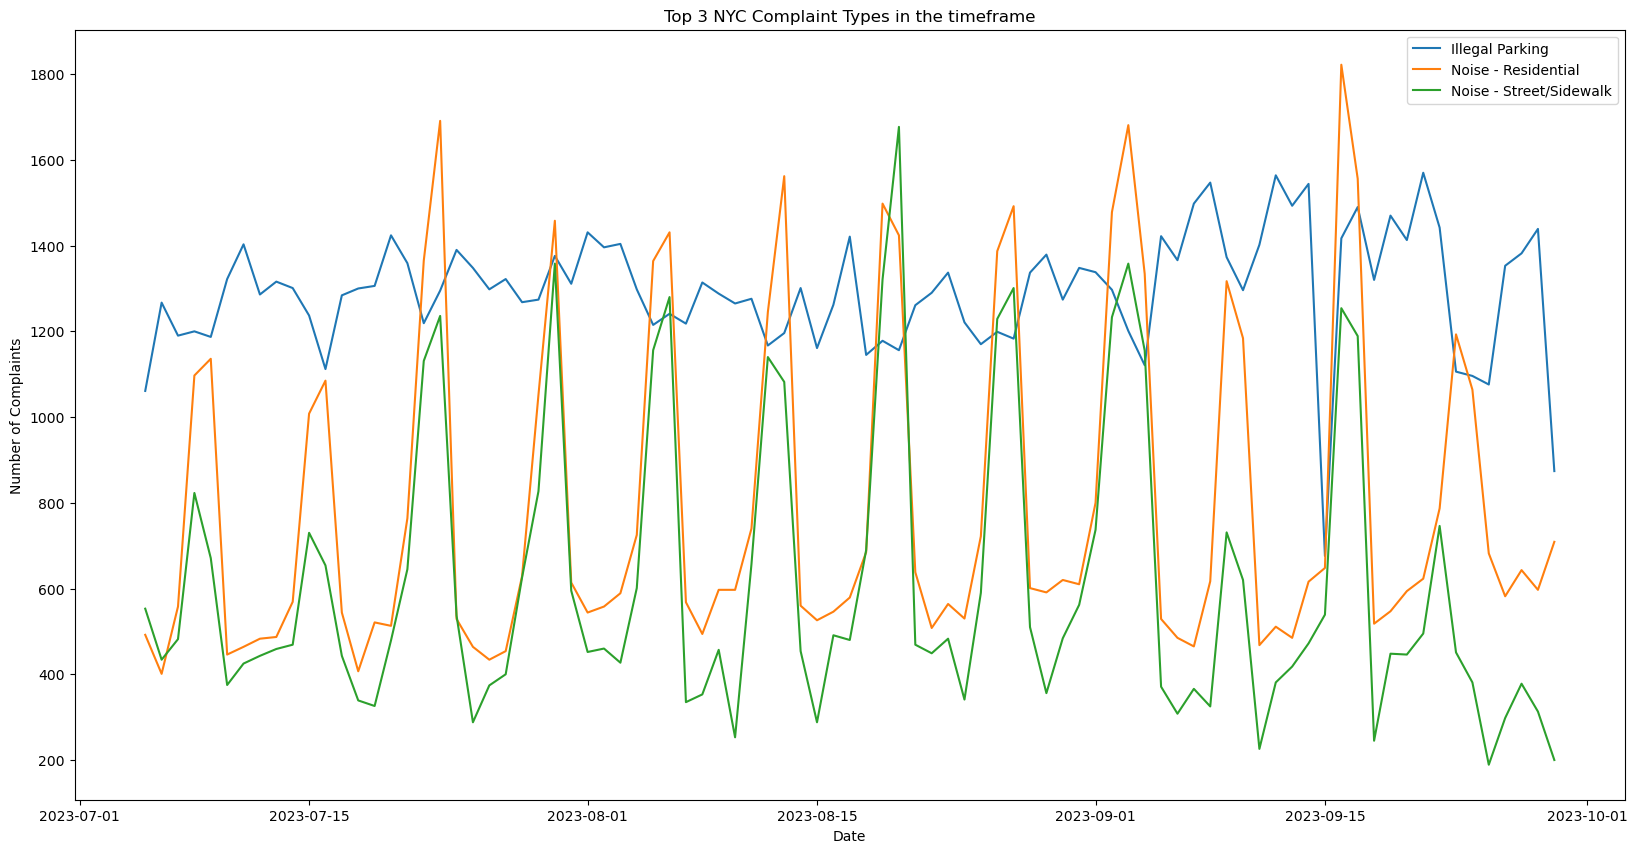

In [50]:
complaints_data1 = get_data_for_visual_1()
plot_visual_1(complaints_data1)

### Visualization 2 What are the most common complaints in the immediate area?
Create a visualization that shows the number of complaints by complaint type for the top 10 complaints in zip code 10027 for October 1st, 2018 to September 30th, 2023 (inclusive). 


In [51]:
def plot_visual_2(dataframe):
    figure, axes = plt.subplots(figsize=(30, 10))
    axes.bar(dataframe['complaint_type'], dataframe['complaint_count'], color='red')

    axes.set_title("Top 10 Complaints in Zip Code 10027 in the timeframe")
    axes.set_xlabel("Complaint Type")
    axes.set_ylabel("Number of Complaints")

    plt.show()

In [56]:
def get_data_for_visual_2():
    complaints_query = """
    SELECT 
        complaint_type, 
        COUNT(*) as complaint_count
    FROM 
        nyc_311
    WHERE 
        incident_zip = 10027::text
        AND
        created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY 
        complaint_type
    ORDER BY 
        complaint_count DESC
    LIMIT 10
    """

    with engine.connect() as conn:
        complaints_data = pd.read_sql(complaints_query, conn)

    return complaints_data

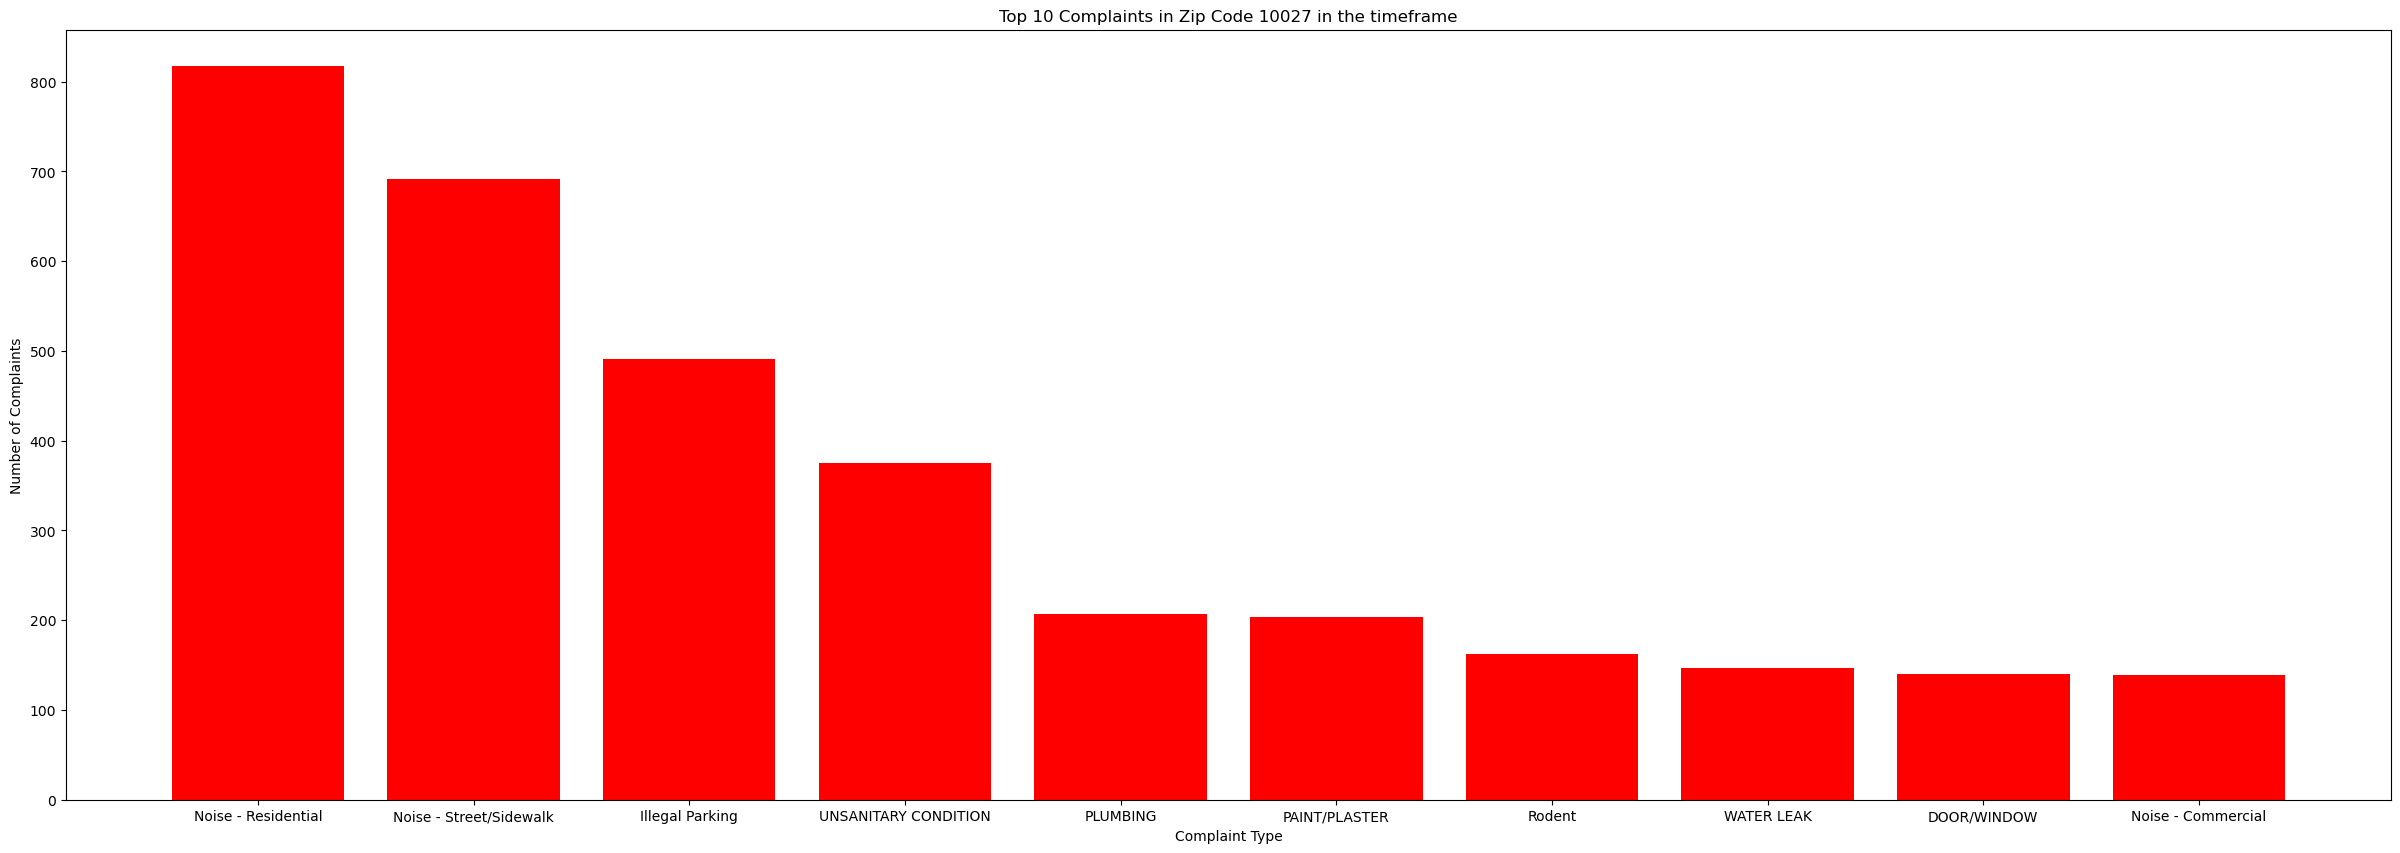

In [57]:
complaints_data2 = get_data_for_visual_2()
plot_visual_2(complaints_data2)

### Visualization 3  Is there any correlation between rent, trees, and complaints at all?
Between January 1st, 2015 and September 30th, 2023 (inclusive), create a visualization using 2 subplots that share the x-axis where one subplot shows rent compared to the number of trees by zip code, and the other subplot shows rent compared to the number of complaints by zip code.

In [67]:
def plot_visual_3(rent_df, tree_df, complaint_df):
    merged_df = rent_df.merge(tree_df, on='zipcode').merge(complaint_df, on='zipcode')

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

    ax1.scatter(merged_df['average_rent'], merged_df['tree_count'], color='blue', alpha=0.7)
    ax1.set_title('Average Rent VS Tree Count by Zipcode')
    ax1.set_ylabel('Tree Count')
    ax1.set_xlabel('Average Rent')

    ax2.scatter(merged_df['average_rent'], merged_df['complaint_count'], color='red', alpha=0.7)
    ax2.set_title('Average Rent VS Complaint Count by Zipcode')
    ax2.set_xlabel('Average Rent')
    ax2.set_ylabel('Complaint Count')

    plt.show()

In [68]:
def get_data_for_visual_3():
    query_rentprice = """
    SELECT 
         CAST(zipcode AS varchar) AS zipcode,
         AVG(rent) as average_rent
    FROM 
         nyc_zillow
    WHERE 
         recorded_date BETWEEN '2015-01-01' AND '2023-09-30'
    GROUP BY 
         zipcode
    """

    query_tree = """
    SELECT 
         CAST(zipcode AS varchar) AS zipcode,
         COUNT(*) as tree_count
    FROM 
         nyc_tree
    WHERE
         status = 'Alive'
    GROUP BY 
         zipcode
    """

    query_311 = """
    SELECT 
         CAST(incident_zip AS varchar) AS zipcode,
         COUNT(*) as complaint_count
    FROM 
         nyc_311
    WHERE 
         created_date BETWEEN '2015-01-01' AND '2023-09-30'
    GROUP BY 
         incident_zip
    """

    with engine.connect() as conn:
        rent = pd.read_sql(query_rentprice, conn)
        tree = pd.read_sql(query_tree, conn)
        complaint = pd.read_sql(query_311, conn)

    return rent, tree, complaint

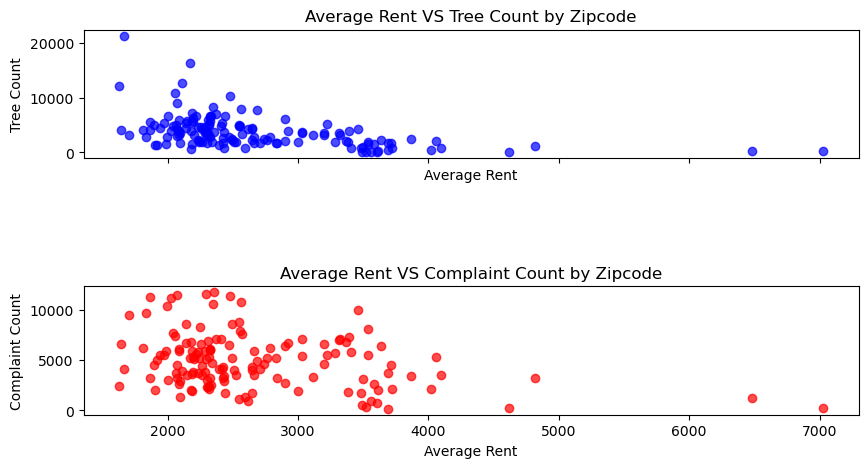

In [69]:
rent, tree, complaint = get_data_for_visual_3()
plot_visual_3(rent, tree, complaint)

### Visualization 4   If I can afford more in rent, will there be fewer issues & complaints?
Create a boxplot, where the x-axis is average rent in September 2023, separated into $1000 bins (i.e. $0-1000, $1001-2000, etc), and the y-axis is the number of 311 complaints observed in each zip code between October 1, 2022 (inclusive) to September 30, 2023 (inclusive).


In [70]:
def plot_visual_4(dataframe):
    fig, ax = plt.subplots(figsize=(20, 10))

    dataframe.boxplot(column='complaint_count', by='rent_bins', ax=ax, grid=False)

    ax.set_title('Number of 311 Complaints compared with Average Rent')
    ax.set_xlabel('Average Rent Bins in $')
    ax.set_ylabel('Number of 311 Complaints')

    plt.show()

In [71]:
def get_data_for_visual_4():
    queryrent = """
    SELECT 
         CAST(zipcode AS varchar) AS zipcode, 
         AVG(rent) as average_rent
    FROM 
         nyc_zillow
    WHERE 
         recorded_date BETWEEN '2023-09-01' AND '2023-09-30'
    GROUP BY 
         zipcode
    """

    querycomplaint = """
    SELECT 
         CAST(incident_zip AS varchar) AS zipcode, 
         COUNT(*) as complaint_count
    FROM 
         nyc_311
    WHERE 
         created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY 
         incident_zip
    """

    with engine.connect() as conn:
        rent_data = pd.read_sql(queryrent, conn)
        complaint_data = pd.read_sql(querycomplaint, conn)

    merged = rent_data.merge(complaint_data, on='zipcode')

    rent_bins = pd.cut(merged['average_rent'], bins=range(0, int(merged['average_rent'].max()) + 1000, 1000), right=False)
    merged['rent_bins'] = rent_bins

    return merged

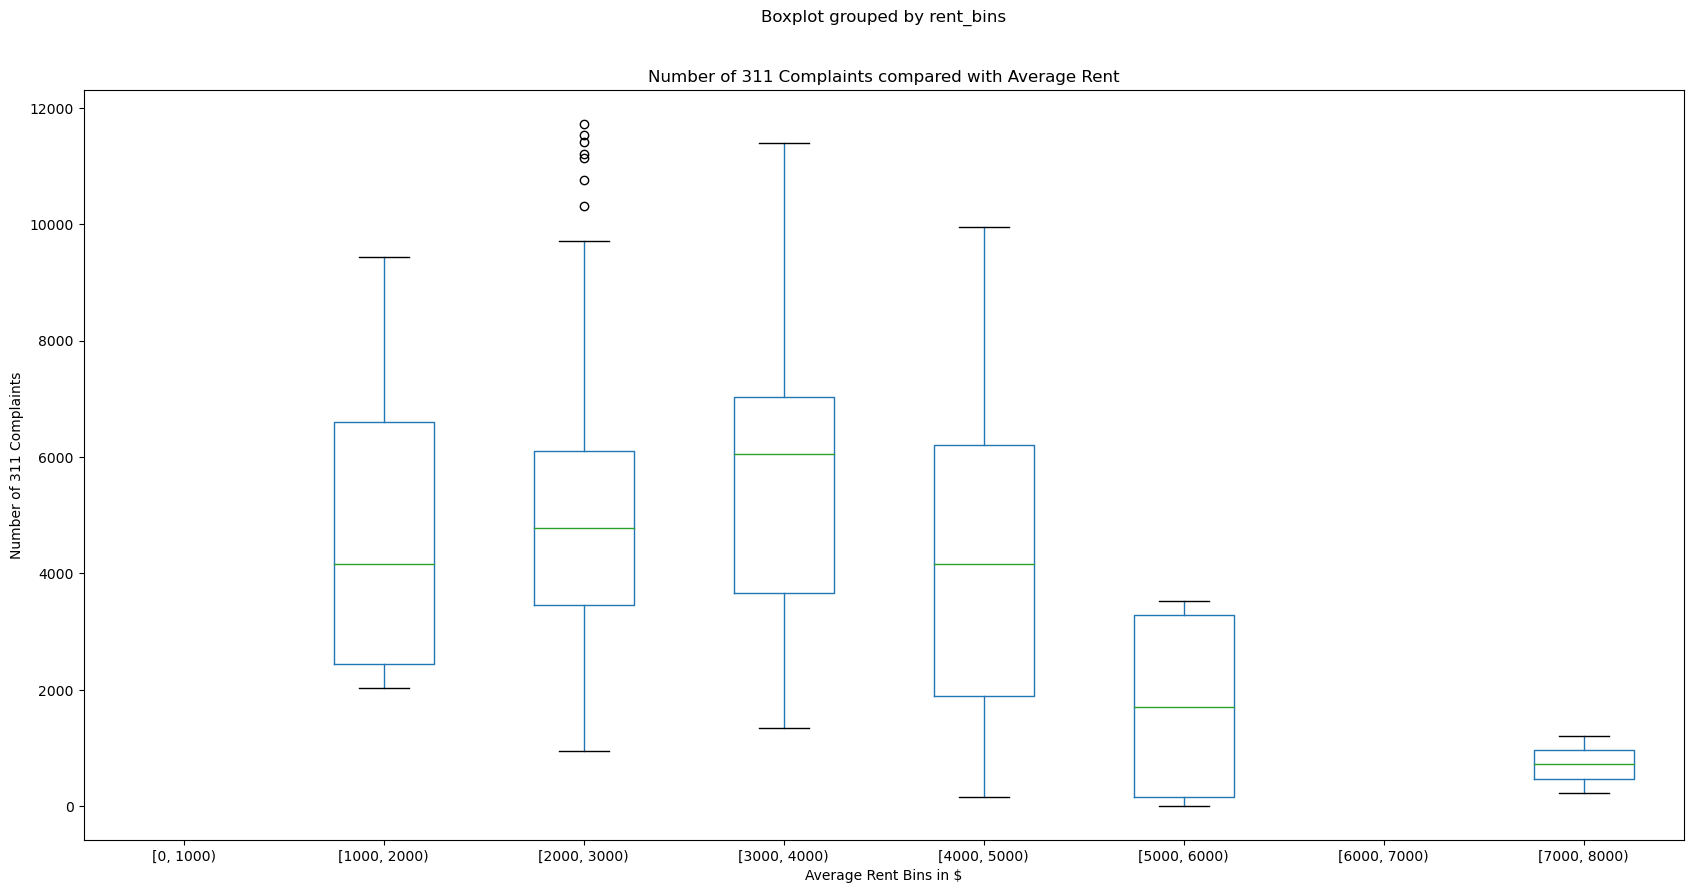

In [72]:
afford_complaint = get_data_for_visual_4()
plot_visual_4(afford_complaint)

### Visualization 5 Where were the recent 311 incidents reported from in the immediate area?
Create a geospatial plot of the coordinates of reported 311 incidents that happened between January 1st, 2023 and September 30th, 2023 (inclusive) within a 1 kilometer radius of the same coordinate from Query 6 in Part 3.


In [73]:
def get_data_for_visual_5():
    latitude = 40.80737875669467
    longitude = -73.96253174434912
    point = Point(longitude, latitude)

    point_wkb = dumps(point, hex=True)

    incident_query = f"""
    SELECT 
         ST_X(geometry::geometry) as longitude, 
         ST_Y(geometry::geometry) as latitude
    FROM 
         nyc_311
    WHERE 
        created_date BETWEEN '2023-01-01' AND '2023-09-30'
        AND ST_DWithin(geometry::geography, ST_GeomFromWKB('\\x{point_wkb}', 4326)::geography, 1000)
    """

    with engine.connect() as conn:
        incidents_data = pd.read_sql(incident_query, conn)

    return incidents_data

In [74]:
def plot_visual_5(dataframe):
    gdf = gpd.GeoDataFrame(dataframe, geometry=gpd.points_from_xy(dataframe['longitude'], dataframe['latitude']))

    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, markersize=5, color='red', marker='o')
    plt.title("311 Incidents Near the coordinate in the timeframe")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")    
       
    plt.show()

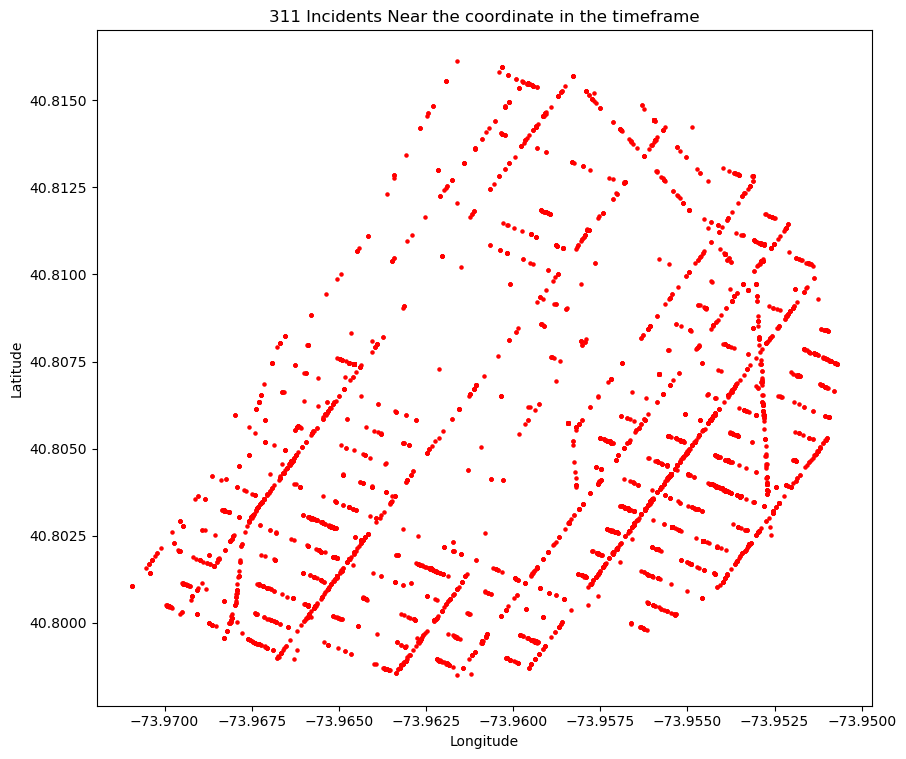

In [75]:
complaints_data5 = get_data_for_visual_5()
plot_visual_5(complaints_data5)

### Visualization 6 Are areas trying to improve the amount of trees in the neighborhood?
Create a geospatial plot of two sets of data: the coordinates of trees in NYC, and the coordinates of "New Tree Request" 311 complaint types that were made from October 1st, 2018 to September 30th, 2023 (inclusive). 


In [76]:
def plot_visual_6(tree_df, complaint_df):
    tree_gdf = gpd.GeoDataFrame(tree_df, geometry=gpd.points_from_xy(tree_df.longitude, tree_df.latitude))
    complaint_gdf = gpd.GeoDataFrame(complaint_df, geometry=gpd.points_from_xy(complaint_df.longitude, complaint_df.latitude))

    fig, ax = plt.subplots(figsize=(10, 10))
    tree_gdf.plot(ax=ax, marker='o', color='green', label='Existing Trees')
    complaint_gdf.plot(ax=ax, marker='x', color='black', label='New Tree Requests')
    plt.title("Comparison of NYC Tree Locations and New Tree Requests in the timeframe")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    plt.show()

In [77]:
def get_data_for_visual_6():

    querytree = """
    SELECT 
        tree_id, 
        ST_Y(geometry::geometry) AS latitude,
        ST_X(geometry::geometry) AS longitude
    FROM 
        nyc_tree
    """

    querycomplaint = """
    SELECT 
        unique_key, 
        ST_Y(geometry::geometry) AS latitude,
        ST_X(geometry::geometry) AS longitude
    FROM 
        nyc_311
    WHERE 
        complaint_type = 'New Tree Request' AND
        created_date BETWEEN '2018-10-01' AND '2023-09-30'
    """

    tree_df = pd.read_sql(querytree, engine)
    complaint_df = pd.read_sql(querycomplaint, engine)

    return tree_df, complaint_df

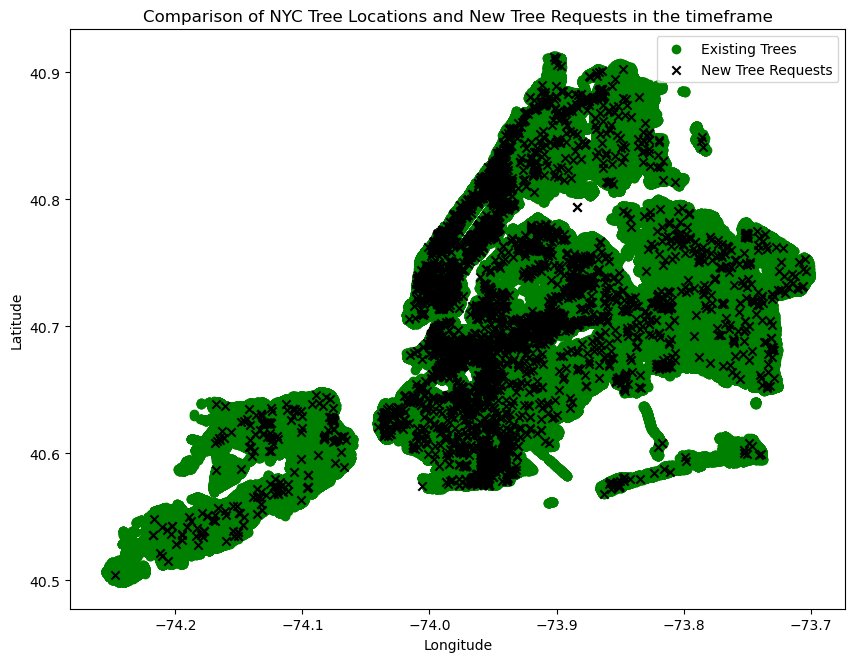

In [78]:
tree_df, complaint_df = get_data_for_visual_6()
plot_visual_6(tree_df, complaint_df)